<div align='left'><font size="4" color="#000000"><h1 style="text-transform: uppercase"><strong>Percentile Capping</strong> </font></div>
<hr>
<div align='left'><font size="3" color="#000000">If a value exceeds the value of the 99th percentile and below the 1st percentile of given values are treated as outliers.</font></div> 
<hr>

In [1]:
# def Winsorization_outliers(df, percentiles=(1, 99)):
#     out, final_index =[], []
#     q1 = np.percentile(df['planned_service_time_log'] , percentiles[0])
#     q3 = np.percentile(df['planned_service_time_log'] , percentiles[1])
#     for index, i in enumerate(df['planned_service_time_log'].values):
#         if i > q3 or i < q1:
#             out.append(index)
#             final_index.append(df.loc[index]['index'])
#     # print("Outliers:",out)
#     return out, final_index
# cap_outliers_index, cap_final_index = Winsorization_outliers(tt.Y_train.reset_index(), percentiles=(10, 90))
# print('#Outliers: ',len(cap_outliers_index))

# # remove outliers from X_train and y_train
# cap_X_train = np.delete(X_train, cap_outliers_index, axis=0)
# cap_y_train = np.delete(y_train, cap_outliers_index)

# # recalculating the pca with the new X_train
# n_components = 5
# pca = PCA(n_components=n_components)
# cap_X_pca = pca.fit_transform(cap_X_train)
# explained_variance=pca.explained_variance_ratio_
# plot_pca(n_components, explained_variance)

# cap_X_pca.shape, cap_y_train.shape

In [43]:
%load_ext autoreload
%autoreload 2

# --------------------------------------------------------------------------------

import os
import sys
from pathlib import Path
import numpy as np
np.warnings.filterwarnings('ignore')

# hex2cec
HOME = os.environ["HOME"]

sys.path.insert(0, f"{os.environ['HOME']}/hex2vec")
sys.path.insert(0, f"{os.environ['HOME']}/amazon-routing-challenge")

# add codebase
sys.path.insert(0, f"/gcsmount-notebook/codebase")

from src.data.make_dataset import h3_to_polygon
import urban_tools.constants as uc
import urban_tools.hex_pipeline as hp
from urban_tools.hex_pipeline import RouteHexHandler, TestTrainManager
from urban_tools.pipelines import route_hex_pipeline
import numpy as np
import plotly.graph_objects as go
import pandas as pd
import geopandas as gpd
import h3
import gcsfs

%matplotlib inline
import matplotlib.pyplot as plt
## Read in the DataFrame

p = Path("/gcsmount-research-data-staging/osmnx-cities/hexed-routes/12.12.22-Revised-Embeddings/hh.pkl")
hh = RouteHexHandler.from_pickle(p)
hh.print_history()
hh = hh.drop_zero_tags()
### Drop Tags that occur in <X% of a City
# percentage = 0.01
# import pandas as pd

# drop_cols = pd.Index([])
# for _hh in [hh]:
#     assert _hh.df["city"].unique().shape[0] == 1
#     h3_df = _hh.df.groupby('h3')[_hh.all_tags].first()
#     percent_occurance = (h3_df > 0).sum() / h3_df.shape[0]
#     drop_cols = drop_cols.union(percent_occurance[percent_occurance < percentage].index)
# hh.drop_cols(drop_cols)
# len(hh.all_tags)
### Append the embedding to the dataframe
# embedding_df = pd.read_parquet(
#     hh.my_folder / "embeddings.prq"
# )
embedding_df = pd.read_feather(
    "/gcsmount-research-data-staging/hex2vec-models/paper-final/embedding_dfs/subtags+cities+littlemodel.feather"
)
embedding_df = embedding_df.set_index("h3")
# embedding_df.columns = [f"e_{e}" for e in embedding_df.columns]
# embedding_df = embedding_df[embedding_df.columns.str.]
# embedding_columns = embedding_df.columns.copy()
# embedding_df = embedding_df.reset_index()

hh.df = hh.df.merge(embedding_df, on="h3", how="left")
hh.update_tags()
hh.df = hh.df.dropna(subset=hh.embeddings)
### Filter for only H3 with > X Data Points

# tagged_df = tagged_df.loc[tagged_df["h3_9"] > 20].copy()
hh.df = hh.df[hh.df.city.str.contains('Boston')]
# hh.df.drop("h3_9", axis=1, inplace=True)
# print(tagged_df.shape)
hh.df = hh.df.reset_index(drop=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
read_cities(*(PosixPath('/gcsmount-research-data-staging/osmnx-cities/hexed-complete'),), **{'cities': ['Boston, USA', 'Austin, USA', 'Seattle, USA', 'Los Angeles, USA'], 'add_city_col': True})
create_super_tags(*(), **{})
Merge building_residential + building_house -> building_yes(*(), **{})
drop_zero_buildings(*(), **{})
drop_zero_building_area(*(), **{})
add_new_special_tag(*('building.area.average',), **{})
add_new_special_tag(*('parking.area.average',), **{})
append_route_df(*(), **{'grouped': False, 'tukey_fences': False})
open_route_df(*(), **{'grouped': False, 'tukey_fences': False})
drop_zero_tags(*(), **{})


<div align='left'><font size="4" color="#000000"><h1 style="text-transform: uppercase"><strong>Percentile Capping</strong> </font></div>
<hr>
<div align='left'><font size="3" color="#000000">If a value exceeds the value of the 99th percentile and below the 1st percentile of given values are treated as outliers.</font></div> 
<hr>

In [44]:
alpha_100 = 5
def Winsorization_outliers(df, percentiles):
    out, df_index =[], []
    q1 = np.percentile(df, percentiles[0])
    q3 = np.percentile(df, percentiles[1])
    for index, i in enumerate(df.values):
        if i > q3 or i < q1:
            out.append(index)
            # df_index.append(df.index)
    # print("Outliers:",out)
    return out
cap_outliers_index = Winsorization_outliers(hh.df['planned_service_time'], percentiles=(alpha_100, 100-alpha_100))
print('#Outliers: ',len(cap_outliers_index))

# # remove outliers from hh
hh.df = hh.df.drop(cap_outliers_index)
hh.df.shape

#Outliers:  2177


(20376, 735)

In [45]:
hh = hh.filter_hex_occurance(20)

### Create the TT Manager

In [46]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn import metrics
from scipy.stats import pearsonr

In [47]:
tt = TestTrainManager(
    hh.df,
    x_col=hh.embeddings.union(hh.special_tags).union(hh.super_tags),
    y_col=["planned_service_time_log"],
    scaler=RobustScaler,
    grouped=False,
    desired_quantiles=[0.5, 0.90]
)

tt.split_test_train(train_size=0.8, random_seed=42)
tt.scale_test_train()
# split the tt.X_test into several chunks. Have to do this because of memory issues
tt.build_test_df(agg=False)

In [48]:
X_train, y_train, X_test, y_test = tt.X_train.values, tt.Y_train.planned_service_time_log.values.ravel(), tt.X_test.values, tt.Y_test.loc.values

In [49]:
X_train.shape, X_test.shape

((11945, 74), (3018, 74))

## PCA

In [50]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
import statistics as stat
from sklearn.linear_model import LinearRegression
import math
from sklearn import metrics
%matplotlib inline

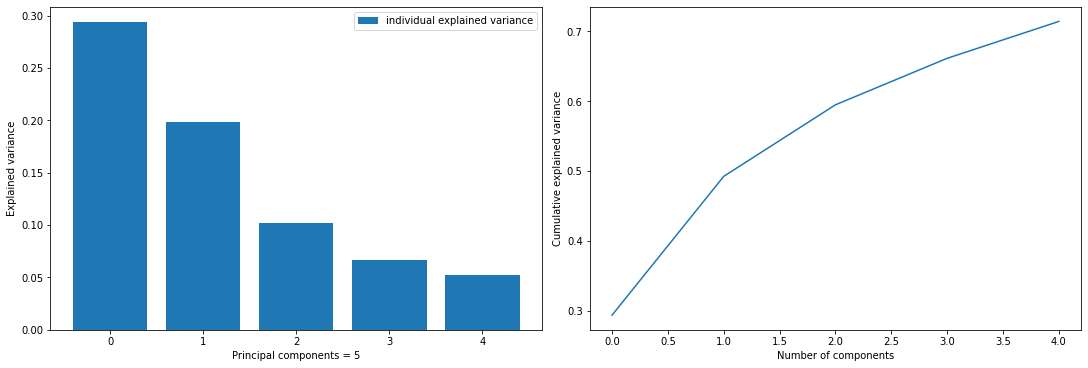

In [51]:
# n_components = X_train.shape[1]
n_components = 5
pca = PCA(n_components=n_components)
# pca = KernelPCA(n_components=n_components, kernel='rbf', gamma=0.1)
X_pca = pca.fit_transform(X_train)

# explained_variance = np.var(X_pca, axis=0) / np.sum(np.var(X_pca, axis=0))

def plot_pca(n_components, explained_variance):
    # create subplots for cumulative explained variance and individual explained variance
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # plot individual explained variance
    ax1.bar(range(n_components), explained_variance, label='individual explained variance')
    ax1.set_xlabel(f'Principal components = {n_components}')
    ax1.set_ylabel('Explained variance')
    ax1.legend()

    # plot cumulative explained variance
    ax2.plot(np.cumsum(explained_variance))
    ax2.set_xlabel('Number of components')
    ax2.set_ylabel('Cumulative explained variance')

    plt.show()

explained_variance=pca.explained_variance_ratio_
plot_pca(n_components, explained_variance)

In [52]:
# def Winsorization_outliers(df, percentiles=(1, 99)):
#     out, final_index =[], []
#     q1 = np.percentile(df['planned_service_time_log'] , percentiles[0])
#     q3 = np.percentile(df['planned_service_time_log'] , percentiles[1])
#     for index, i in enumerate(df['planned_service_time_log'].values):
#         if i > q3 or i < q1:
#             out.append(index)
#             final_index.append(df.loc[index]['index'])
#     # print("Outliers:",out)
#     return out, final_index
# cap_outliers_index, cap_final_index = Winsorization_outliers(tt.Y_train.reset_index(), percentiles=(10, 90))
# print('#Outliers: ',len(cap_outliers_index))

# # remove outliers from X_train and y_train
# cap_X_train = np.delete(X_train, cap_outliers_index, axis=0)
# cap_y_train = np.delete(y_train, cap_outliers_index)

# # recalculating the pca with the new X_train
# n_components = 5
# pca = PCA(n_components=n_components)
# cap_X_pca = pca.fit_transform(cap_X_train)
# explained_variance=pca.explained_variance_ratio_
# plot_pca(n_components, explained_variance)

# cap_X_pca.shape, cap_y_train.shape

<div align='left'><font size="4" color="#000000"><h1 style="text-transform: uppercase"><strong>IQR method</strong> </font></div>
<hr>
<div align='left'><font size="3" color="#000000">In this method by using Inter Quartile Range(IQR), we detect outliers. IQR tells us the variation in the data set.Any value, which is beyond the range of -1.5 x IQR to 1.5 x IQR treated as outliers </font></div> 
<hr>
<img style="float: center;"  src=" https://miro.medium.com/max/18000/1*2c21SkzJMf3frPXPAR_gZA.png" width="400px">
<hr> 
<div align='left'><font size="3" color="#000000">* Q1 represents the 1st quartile/25th percentile of the data.</font></div> 
<div align='left'><font size="3" color="#000000">* Q2 represents the 2nd quartile/median/50th percentile of the data.</font></div>
<div align='left'><font size="3" color="#000000">* Q3 represents the 3rd quartile/75th percentile of the data. </font></div>
<div align='left'><font size="3" color="#000000">* (Q1–1.5*IQR) represent the smallest value in the data set and (Q3+1.5*IQR)
    represnt the largest value in the data set.</font></div>



In [53]:
# import pandas as pd
# import numpy as np

# def iqr_outliers(df):
#     out=[]
#     q1 = df.quantile(0.25).values[0]
#     q3 = df.quantile(0.75).values[0]
#     iqr = q3-q1
#     Lower_tail = q1 - 1.5 * iqr
#     Upper_tail = q3 + 1.5 * iqr
#     for index, i in enumerate(df.values):
#         if i[0] > Upper_tail or i[0] < Lower_tail:
#             out.append(index)
#     # print("Outliers:",out)
#     return out
# ipr_outliers_index = iqr_outliers(pd.DataFrame(y_train))
# print('#Outliers: ',len(ipr_outliers_index))

# # remove outliers from X_train and y_train
# ipr_X_train = np.delete(X_train, ipr_outliers_index, axis=0)
# ipr_y_train = np.delete(y_train, ipr_outliers_index)

# # recalculating the pca with the new X_train
# n_components = 5
# pca = PCA(n_components=n_components)
# cap_X_pca = pca.fit_transform(ipr_X_train)
# explained_variance=pca.explained_variance_ratio_
# plot_pca(n_components, explained_variance)

# ipr_X_train.shape, ipr_y_train.shape

## Modelling using GP Regression

In [54]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

# Make plots inline
%matplotlib inline

In [55]:
# data_dim = X_train.shape[1]

# # Same architechture as the MLP neural network
# class LargeFeatureExtractor(torch.nn.Sequential):
#     def __init__(self):
#         super(LargeFeatureExtractor, self).__init__()
#         self.add_module('linear1', torch.nn.Linear(data_dim, 16))
#         self.add_module('relu1', torch.nn.ReLU())
#         self.add_module('linear2', torch.nn.Linear(16, 32))
#         self.add_module('relu2', torch.nn.ReLU())
#         self.add_module('linear3', torch.nn.Linear(32, 128))
#         self.add_module('relu3', torch.nn.ReLU())
#         self.add_module('linear4', torch.nn.Linear(128, 32))
#         self.add_module('relu4', torch.nn.ReLU())
#         self.add_module('linear5', torch.nn.Linear(32, 16))
#         self.add_module('relu5', torch.nn.ReLU())
#         self.add_module('linear6', torch.nn.Linear(16, 2))

# feature_extractor = LargeFeatureExtractor()

In [56]:
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.base_covar_module = gpytorch.kernels.RBFKernel()
            self.covar_module = gpytorch.kernels.AdditiveStructureKernel(
                gpytorch.kernels.ScaleKernel(
                    gpytorch.kernels.GridInterpolationKernel(self.base_covar_module, grid_size=128, num_dims=1)
                ), num_dims=train_x.shape[-1]
            )
            # This leads to crashing of the kernel :/
            # gpytorch.kernels.GridInterpolationKernel(
            #     gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=n_components)),
            #     num_dims=n_components, grid_size=64
            # )
            # self.feature_extractor = feature_extractor

            # self.covar_module = gpytorch.kernels.GridInterpolationKernel(
            #     gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
            #     num_dims=2, grid_size=256
            # )

            # PCA based feature extractor
        
            self.feature_extractor = PCA(n_components=n_components)

            # This module will scale the NN features so that they're nice values
            self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            # projected_x = self.feature_extractor(x)
            projected_x = torch.Tensor(self.feature_extractor.fit_transform(x))
            projected_x = self.scale_to_bounds(projected_x)  # Make the NN values "nice"

            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [103]:
from tqdm import tqdm
training_iterations = 2000

# load the saved model
# state_dict = torch.load('model_state.pth')

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(torch.Tensor(X_train), torch.Tensor(y_train), likelihood)

# model.load_state_dict(state_dict)

if torch.cuda.is_available():
    model = model
    likelihood = likelihood

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    # {'params': model.feature_extractor.parameters()},
    {'params': model.covar_module.parameters()},
    {'params': model.mean_module.parameters()}, 
    {'params': model.likelihood.parameters()},
], lr=1e-3)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

train_losses = []

def train():
    iterator = tqdm(range(training_iterations))
    for i in iterator:
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(torch.Tensor(X_train))
        # Calc loss and backprop derivatives
        loss = -mll(output, torch.Tensor(y_train))
        loss.backward()
        train_losses.append(loss.item())
        iterator.set_postfix(loss=loss.item())
        optimizer.step()

%time train()

100%|██████████| 2000/2000 [3:08:02<00:00,  5.64s/it, loss=0.95]   

CPU times: user 11h 15min 47s, sys: 1h 33min 21s, total: 12h 49min 9s
Wall time: 3h 8min 2s


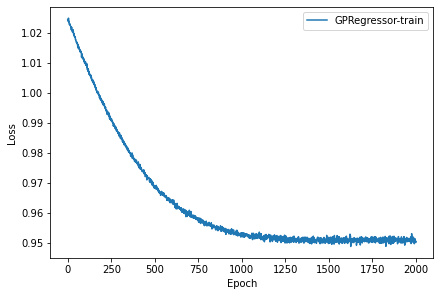

In [104]:
# plot the loss
plt.plot(train_losses, label='GPRegressor-train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [211]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    training_preds = model(torch.Tensor(X_train))

# Testing on the hexagonal level though
h3_index = hh.df.loc[tt._test_slice, 'h3']
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    preds = model(torch.Tensor(tt.X_test.groupby(h3_index).first().values))

In [212]:
# This is wrong and messes up the predictions
preserved_unique_h3_index = list(dict.fromkeys(hh.df.loc[tt._test_slice, 'h3']))
y_test_df = pd.DataFrame(index=preserved_unique_h3_index)
y_test_df['mean'] = tt.scaler.Y.transform(hh.df.loc[tt._test_slice, 'planned_service_time_log'].groupby(h3_index).mean().values.reshape(-1,1)).ravel()
y_test_df['std'] =  tt.Y_test.loc.groupby(h3_index).std().values.ravel()
y_test_std = y_test_df['std']
# y_data = pd.DataFrame({'y_test':y_test, 'y_test_mean_pred':preds.mean.ravel()}, index = h3_index)

In [224]:
print('Mean-predicitions')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, training_preds.mean):.3f}, Train RMSE: {mean_squared_error(y_train, training_preds.mean, squared=False):.3f}, Train R2: {r2_score(y_train, training_preds.mean):.3f}')
print(f"Test MAPE: {mean_absolute_percentage_error(y_test_df['mean'].values, preds.mean):.3f}, Test RMSE: {mean_squared_error(torch.Tensor(y_test_df['mean'].values), preds.mean, squared=False):.3f}, Test R2: {r2_score(torch.Tensor(y_test_df['mean'].values), preds.mean):.3f}")
print('-'*50)
print('Variance-predicitions')
# np.where(y_test_std.isna())
nnull = np.where(y_test_std.notnull())[0]
# print(f'Train MAPE: {mean_absolute_percentage_error(tt.Y_train.scale, training_preds.variance**0.5):.3f}, Train RMSE: {mean_squared_error(tt.Y_train.scale, training_preds.variance**0.5, squared=False):.3f}, Train R2: {r2_score(tt.Y_train.scale, training_preds.variance**0.5):.3f}')
print(f'Test MAPE: {mean_absolute_percentage_error(y_test_std[nnull], preds.variance[nnull]**0.5):.3f}, Test RMSE: {mean_squared_error(y_test_std[nnull], preds.variance[nnull]**0.5, squared=False):.3f}, Test R2: {r2_score(y_test_std[nnull], preds.variance[nnull]**0.5):.3f}')


torch.save(model.state_dict(), './model_state.pth')

Mean-predicitions
Train MAPE: 2061249802738.309, Train RMSE: 0.621, Train R2: 0.081
Test MAPE: 2.100, Test RMSE: 0.185, Test R2: 0.447
--------------------------------------------------
Variance-predicitions
Test MAPE: 0.961, Test RMSE: 0.571, Test R2: -60.344


## Trying to understand intra hex variance now

* get empirical points for every hexagon!

In [214]:
empirical_pts_df = hh.df.loc[hh.df['h3'].isin(y_test_df.index)].groupby('h3').apply(lambda x: x['planned_service_time'].values)
empirical_pts_df = empirical_pts_df[y_test_df.index]
# y_test_std = np.array([tt.scaler.Y.transform(x.reshape(-1, 1)).std() for x in empirical_pts_df.values])

In [215]:
# difference between predicted and empiral distribution hexagon wise

# 1. using predictions from GP Regression model
import scipy

test_df = tt.X_test.groupby(h3_index).first()

# conversion of log mean and std to the original scale
test_df['actual_mean'], test_df['actual_std'] = np.array([x.mean() for x in empirical_pts_df.values]), np.array([x.std() for x in empirical_pts_df.values])

pred_mean, pred_std = tt.scaler.Y.inverse_transform(preds.mean.reshape(-1, 1)), tt.scaler.Y.inverse_transform((preds.variance**0.5).reshape(-1, 1))

In [216]:
# y_pred_samples = np.exp(np.random.normal(loc=pred_mean, scale=pred_std, size=(test_df.shape[0], 10000)))
y_pred_samples = np.exp(tt.scaler.Y.inverse_transform(np.random.normal(loc=preds.mean.reshape(-1, 1), scale=(preds.variance**0.5).reshape(-1, 1), size=(test_df.shape[0], 10000)).flatten().reshape(-1, 1)).reshape(test_df.shape[0], 10000))
test_df['pred_mean'], test_df['pred_std'] = y_pred_samples.mean(axis=1), y_pred_samples.std(axis=1)

#### Wasserstein Distance between predicted distribution and empirical points: 

In [217]:
waserstein_distance = []
for group in hh.df.loc[hh.df['h3'].isin(test_df.index)].groupby('h3'):
    id_ = test_df.index.get_loc(group[1]['h3'].tolist()[0])
    waserstein_distance.append([group[1]['h3'].tolist()[0],scipy.stats.wasserstein_distance(y_pred_samples[id_], empirical_pts_df.values[id_])])

test_df = test_df.join(pd.DataFrame(waserstein_distance).set_index(0)).rename(columns={1:'wasserstein_distance'})

In [218]:
hh.df.loc[hh.df['h3'].isin(test_df.index)][['lat','lng', 'planned_service_time']].to_csv('scatter_points.csv')

In [219]:
test_df.head()

,aeroway,amenity,building,building.area,building.area.average,building.area.ratio,e_0,e_1,e_10,e_11,...,shop,sport,tourism,water,waterway,actual_mean,actual_std,pred_mean,pred_std,wasserstein_distance
h3,,,,,,,,,,,,,,,,,,,,,
892a306410fffff,0.0,4.000000,-0.547368,-0.065590,1.433399,-0.064342,-1.429960,-0.485069,0.580569,-0.295925,...,11.0,0.0,1.0,0.0,0.0,140.781818,65.478787,134.824567,6.842596,47.004244
892a306411bffff,0.0,1.666667,-0.210526,0.172567,0.974830,0.173270,-0.502846,-1.510168,-0.425405,0.083354,...,5.0,0.0,0.0,0.0,0.0,190.904000,108.449171,134.308559,4.370534,89.180504
892a3064137ffff,0.0,-0.166667,-0.231579,-0.359579,0.185610,-0.357725,-0.828983,-0.773460,1.116773,-1.114599,...,0.0,0.0,0.0,0.0,1.0,194.500000,124.165879,124.085712,2.487924,104.736946
892a3064147ffff,0.0,-0.333333,-0.221053,-0.840452,-0.583002,-0.838221,-0.077459,0.209420,0.167573,-0.800889,...,0.0,0.0,0.0,0.0,0.0,185.576087,100.589323,111.875958,1.827202,88.486481
892a306418fffff,0.0,1.000000,-0.557895,-0.439340,0.734619,-0.437707,-1.465279,-0.587811,-0.104442,-0.587934,...,1.0,3.0,1.0,0.0,2.0,162.673333,97.423341,128.923881,7.650821,68.161231


In [220]:
largest_var_df = test_df.nlargest(100, 'wasserstein_distance')
smallest_var_df = test_df.nsmallest(100, 'wasserstein_distance')
largest_var_df.to_csv('intrahex_largest_var_df.csv')
smallest_var_df.to_csv('intrahex_smallest_var_df.csv')

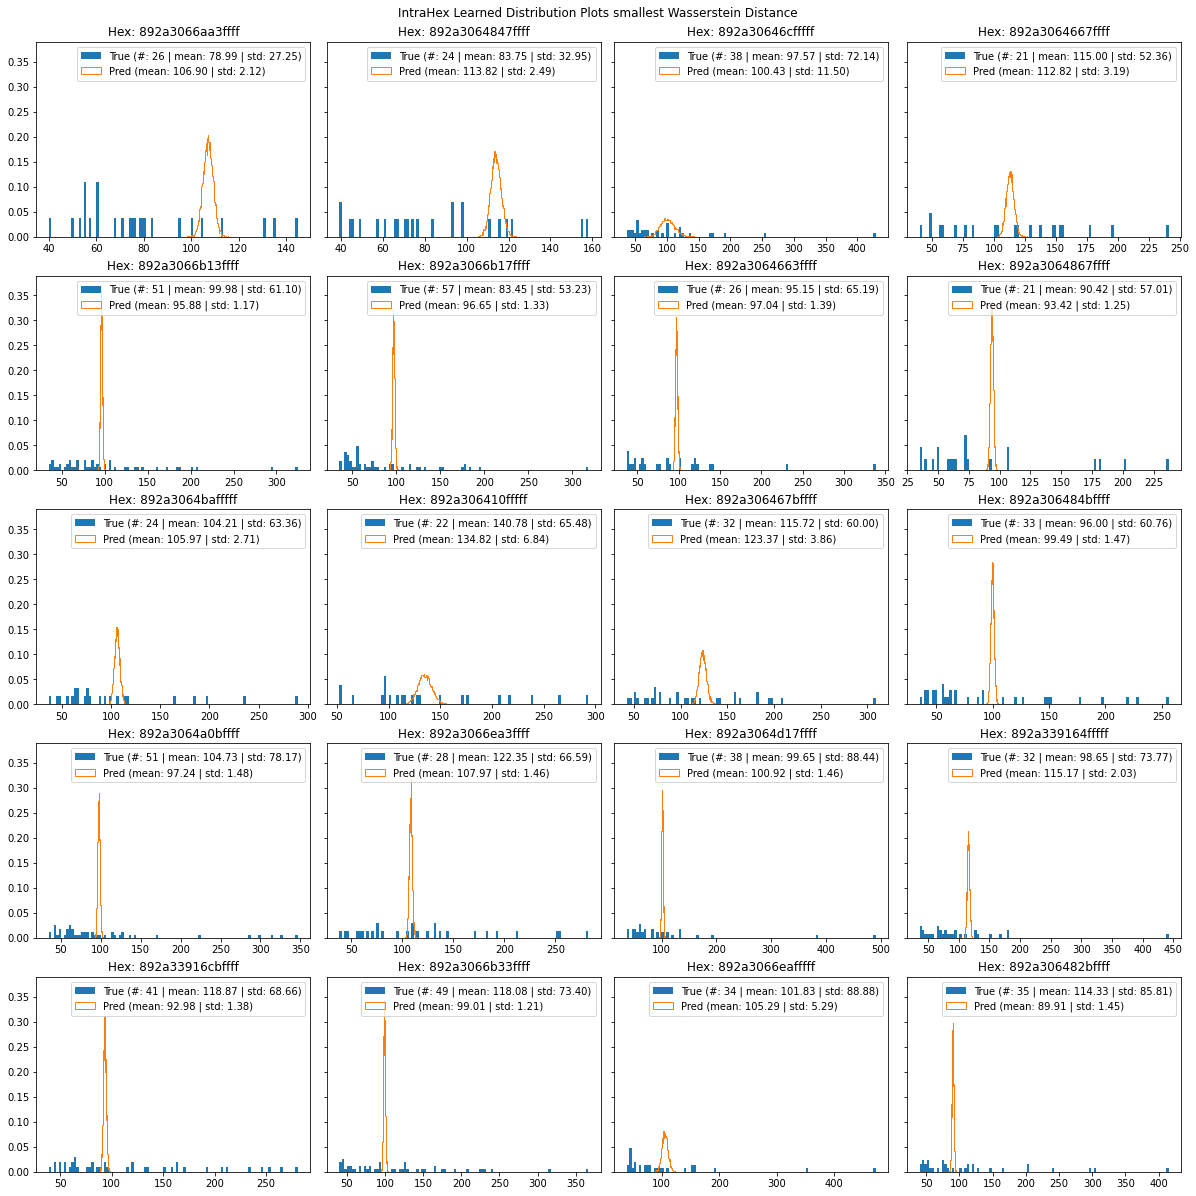

In [221]:
plt.rcParams['figure.constrained_layout.use'] = True
def dist_subplots(df, title):
    rows, cols = 5, 4
    fig, axes = plt.subplots(rows, cols, figsize=(16.5, 16.5), sharey=True)
    fig.suptitle(title)
    count = 0
    for i in range(rows):
        for j in range(cols):
            # emp_pnts = hh.df.loc[hh.df['h3']==df.iloc[count].name]['planned_service_time'].to_list()
            # y_samples = np.random.normal(loc=df.iloc[count]['pred_mean'], scale=df.iloc[count]['pred_std'], size=10000,)
            # y_samples = np.clip(np.exp(y_samples), 0, 10000)
            id_ = test_df.index.get_loc(df.iloc[count].name)
            axes[i, j].hist(empirical_pts_df.values[id_], bins=100, density=True, label=f'True (#: {len(empirical_pts_df.values[id_])} | mean: {test_df.iloc[id_].actual_mean:.2f} | std: {test_df.iloc[id_].actual_std:.2f})')
            axes[i, j].hist(y_pred_samples[id_], bins=100, density=True, histtype='step', label=f'Pred (mean: {test_df.iloc[id_].pred_mean:.2f} | std: {test_df.iloc[id_].pred_std:.2f})')
            axes[i, j].set_title(f'Hex: {df.iloc[count].name}')
            axes[i, j].legend()
            # axes[i, j].set_ylim(0, 1)
            # axes[i, j].set_xlim(0, 1)
            count += 1
    plt.tight_layout()


dist_subplots(smallest_var_df, 'IntraHex Learned Distribution Plots smallest Wasserstein Distance')

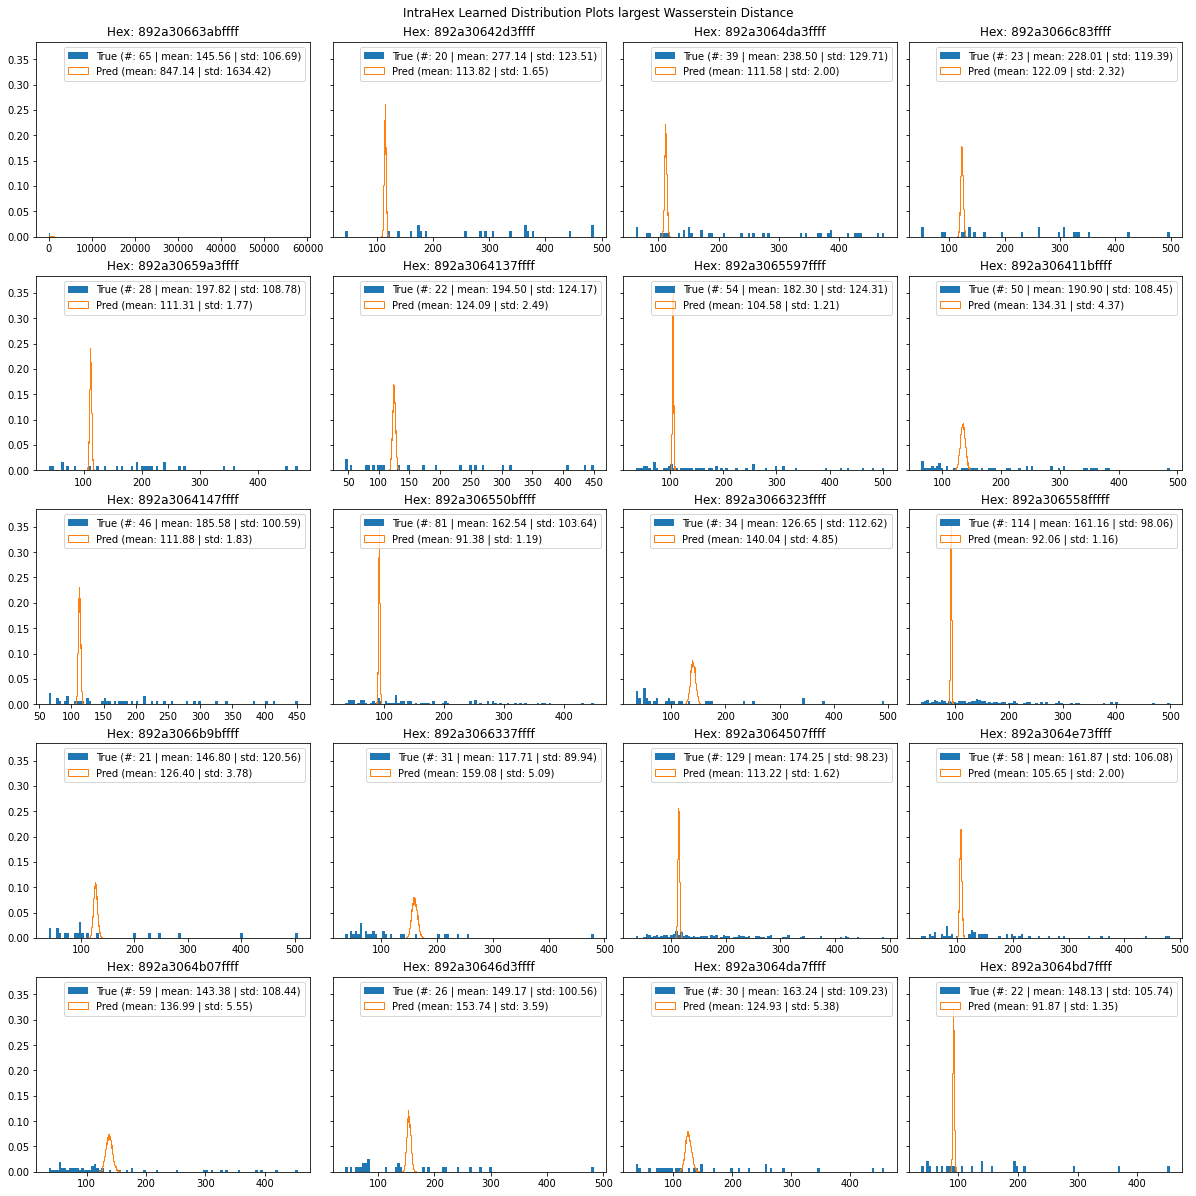

In [222]:
dist_subplots(largest_var_df, 'IntraHex Learned Distribution Plots largest Wasserstein Distance')


### Plot wasserstein distance distribution

<AxesSubplot: title={'center': 'Wasserstein Distance Histogram'}, ylabel='Frequency'>

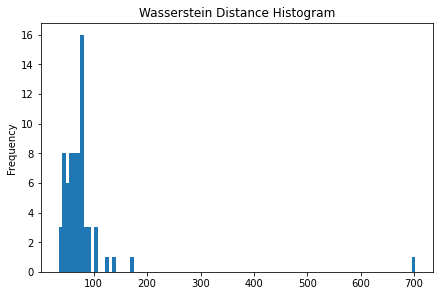

In [223]:
test_df['wasserstein_distance'].plot.hist(bins=100, title='Wasserstein Distance Histogram')